In [1]:
# pip install konlpy

In [40]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import urllib.request
from konlpy.tag import *
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x25a8ce3fd90>)

In [3]:
dataset = pd.read_table("ratings_total.txt")
dataset.head()

,5,배공빠르고 굿
0,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
1,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
2,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
3,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
4,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...


In [4]:
# 결측값 확인하기
dataset.isna().sum()

5          0
배공빠르고 굿    0
dtype: int64

In [5]:
# 컬럼 이름 만들어주기
dataset = pd.read_table("ratings_total.txt", names=["ratings", "reviews"])
dataset

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...,...
199995,2,장마라그런가!!! 달지않아요
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
199998,5,넘이쁘고 쎄련되보이네요~


In [6]:
# 중복 데이터 제거하기
dataset = dataset.drop_duplicates(["reviews"]).reset_index(drop=True)
dataset.head()

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [7]:
# 한글이 아닌 문자 제거
dataset["reviews"] = dataset["reviews"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", ' ', regex=True)
dataset.head()

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서 개 더 구매했어요 이가격에 대박입니다 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다 전...
4,5,민트색상 예뻐요 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [8]:
dataset["ratings"].unique()

array([5, 2, 1, 4], dtype=int64)

In [9]:
# ratings 라벨링 하기
# ratings가 5를 넘으면 1(긍정), 5미만이면 0(부정)
# dataset["label"] = np.select([dataset.ratings > 3], [1], default=0)
dataset["label"] = dataset["ratings"].apply(lambda x: 1 if x > 3 else 0)
dataset.head()

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서 개 더 구매했어요 이가격에 대박입니다 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다 전...,0
4,5,민트색상 예뻐요 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [10]:
# 훈련/테스트 데이터 분리
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=2024)
print(len(train_data))
print(len(test_data))

159926
39982


In [11]:
os.environ["JAVA_HOME"] = r"C:\Program Files\Java\jdk-22\bin\server"

In [12]:
okt = Okt()
print(okt.morphs("와 진짜 vscode 사용하기 귀찮네, 파이참 사용해야 하나?"))

['와', '진짜', 'vscode', '사용', '하기', '귀찮네', ',', '파', '이참', '사용', '해야', '하나', '?']


In [13]:
# 불용어 제거하기 위한 설정
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [14]:
# 토큰화 하기
train_data["tokenized"] = train_data["reviews"].apply(okt.morphs)
train_data["tokenized"] = train_data["tokenized"].apply(lambda x: [word for word in x if word not in stopwords])
train_data.head()

,ratings,reviews,label,tokenized
155437,4,무게는 성인 여자가 들고 다니기엔 무겁지만 그래도 설치가 간편하고 크기가 엄청 커서...,1,"[무게, 성인, 여자, 들고, 다니, 기, 엔, 무겁지만, 그래도, 설치, 간편하고..."
22187,5,꼬소하니 건강음료에요,1,"[꼬소하, 니, 건강, 음료, 에요]"
56237,1,생각보다 품질이 별로인 것 같아요,0,"[생각, 보다, 품질, 별로, 것, 같아요]"
102941,1,선반하나는 휘어져와서 문의남겼더니 전화주실줄알았는데 댓글만 남겨두셨네요 말씀드린것처...,0,"[선반, 하나, 휘, 어, 져와, 서, 문의, 남겼더니, 전화, 주실줄, 알았는데,..."
73392,5,색상넘예뻐서 샀어요 아이도 좋아하네요 학교갖고감 잊어버릴수있다며 집에서 쓴다는데 ㅋ...,1,"[색상, 넘, 예뻐서, 샀어요, 아이, 좋아하네요, 학교, 갖고, 감, 잊어버릴수있..."


In [15]:
test_data["tokenized"] = test_data["reviews"].apply(okt.morphs)
test_data["tokenized"] = test_data["tokenized"].apply(lambda x: [word for word in x if word not in stopwords])
test_data.head()

,ratings,reviews,label,tokenized
74842,5,선풍기랑 노트북에 붙히려고 샀는데 넘 좋아요,1,"[선풍기, 랑, 노트북, 붙히려고, 샀는데, 넘, 좋아요]"
109950,2,제품이 잘못배송된건가요 가 왔어요,0,"[제품, 잘못, 배송, 된건, 가요, 왔어요]"
181885,5,정말 너무 너무 귀엽습니다 ㅠ ㅠ,1,"[정말, 너무, 너무, 귀엽습니다, ㅠ, ㅠ]"
2845,2,길이가 짧아서 조금 불편하네요,0,"[길이, 짧아서, 조금, 불편하네요]"
184584,5,안먹어봤지만 상품은 잘 도착했어요 ㅎ,1,"[안, 먹어, 봤지만, 상품, 잘, 도착, 했어요, ㅎ]"


In [16]:
# 단어와 길이 분포 확인하기
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [17]:
# 부정리뷰 빈도수가 높은 상위 20개 단어 출력하기
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('너무', 14005), ('안', 12608), ('요', 12552), ('배송', 9728), ('그냥', 9070), ('잘', 8406), ('로', 6103), ('했는데', 6051), ('별로', 5975), ('못', 5592), ('제품', 5342), ('좀', 5301), ('생각', 5293), ('으로', 5290), ('사용', 5228), ('하고', 5037), ('ㅠㅠ', 4977), ('보다', 4931), ('구매', 4884), ('만', 4319)]


In [18]:
# 긍정리뷰 빈도수가 높은 상위 20개 단어 출력하기
positive_words_count = Counter(positive_words)
print(positive_words_count.most_common(20))

[('잘', 16457), ('좋아요', 15389), ('배송', 12992), ('너무', 9721), ('재구매', 9219), ('구매', 7553), ('요', 7112), ('사용', 5760), ('가격', 5382), ('같아요', 4747), ('으로', 4710), ('로', 4660), ('좋네요', 4517), ('보다', 4233), ('제품', 4222), ('빠르고', 4211), ('주문', 4145), ('입니다', 4059), ('생각', 3751), ('더', 3579)]


긍정 리뷰의 평균 길이 : 10.775689599119714
부정 리뷰의 평균 길이 : 14.121460376225736


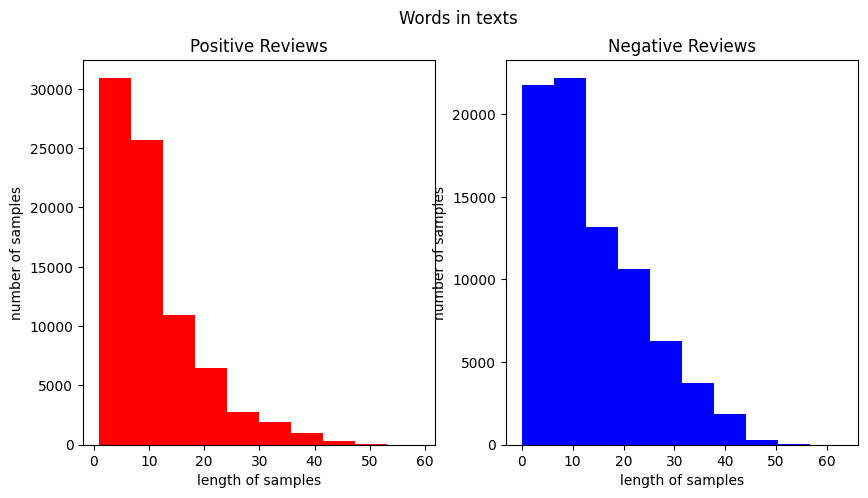

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [20]:
train_data

,ratings,reviews,label,tokenized
155437,4,무게는 성인 여자가 들고 다니기엔 무겁지만 그래도 설치가 간편하고 크기가 엄청 커서...,1,"[무게, 성인, 여자, 들고, 다니, 기, 엔, 무겁지만, 그래도, 설치, 간편하고..."
22187,5,꼬소하니 건강음료에요,1,"[꼬소하, 니, 건강, 음료, 에요]"
56237,1,생각보다 품질이 별로인 것 같아요,0,"[생각, 보다, 품질, 별로, 것, 같아요]"
102941,1,선반하나는 휘어져와서 문의남겼더니 전화주실줄알았는데 댓글만 남겨두셨네요 말씀드린것처...,0,"[선반, 하나, 휘, 어, 져와, 서, 문의, 남겼더니, 전화, 주실줄, 알았는데,..."
73392,5,색상넘예뻐서 샀어요 아이도 좋아하네요 학교갖고감 잊어버릴수있다며 집에서 쓴다는데 ㅋ...,1,"[색상, 넘, 예뻐서, 샀어요, 아이, 좋아하네요, 학교, 갖고, 감, 잊어버릴수있..."
...,...,...,...,...
178715,4,가성비 좋네요 부직포랑 비닐부분이조금 얇은것빼고는요 그래도 또살것같아요,1,"[가성, 비, 좋네요, 부직포, 랑, 비닐, 부분, 조금, 얇은것, 빼고는요, 그래..."
166528,5,무난한 상품입니다,1,"[무난, 상품, 입니다]"
51808,5,선물로줬는데 향이너무좋다고해요,1,"[선물, 로, 줬는데, 향, 너무, 좋다, 고해, 요]"
52730,1,찌그러져서 배송됐어요,0,"[찌그러져서, 배송, 됐어요]"


In [21]:
# 훈련/테스트 데이터 나누기
X_train, y_train = train_data["tokenized"].values, train_data["label"].values
X_test, y_test = test_data["tokenized"].values, test_data["label"].values
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(159926,) (159926,)
(39982,) (39982,)


In [22]:
X_train

array([list(['무게', '성인', '여자', '들고', '다니', '기', '엔', '무겁지만', '그래도', '설치', '간편하고', '크기', '엄청', '커서', '만족', '합니다']),
       list(['꼬소하', '니', '건강', '음료', '에요']),
       list(['생각', '보다', '품질', '별로', '것', '같아요']), ...,
       list(['선물', '로', '줬는데', '향', '너무', '좋다', '고해', '요']),
       list(['찌그러져서', '배송', '됐어요']),
       list(['맛', '좋고', '종류', '다양해서', '좋지만', '간', '좀', '있는', '편입', '니'])],
      dtype=object)

In [23]:
# 정수 인코딩하기
vectorizer = CountVectorizer(max_features=10000)

# CountVectorizer로 처리하기 위해 문자열로 변환
corpus_train = [" ".join(words) for words in X_train]
corpus_test = [" ".join(words) for words in X_test]

# 데이터를 문장 형태로 변환 후 벡터로 변환하고 배열로 저장
X_train_encoded = vectorizer.fit_transform(corpus_train).toarray()
X_test_encoded = vectorizer.transform(corpus_test).toarray()
X_train

array([list(['무게', '성인', '여자', '들고', '다니', '기', '엔', '무겁지만', '그래도', '설치', '간편하고', '크기', '엄청', '커서', '만족', '합니다']),
       list(['꼬소하', '니', '건강', '음료', '에요']),
       list(['생각', '보다', '품질', '별로', '것', '같아요']), ...,
       list(['선물', '로', '줬는데', '향', '너무', '좋다', '고해', '요']),
       list(['찌그러져서', '배송', '됐어요']),
       list(['맛', '좋고', '종류', '다양해서', '좋지만', '간', '좀', '있는', '편입', '니'])],
      dtype=object)

In [36]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(dataset["ratings"])

In [24]:
# 파이토치 텐서로 변환
X_train_tensor = torch.tensor(X_train_encoded, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_encoded, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [27]:
# 데이터셋 클래스 정의
class NewsGroupDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [28]:
train_dataset = NewsGroupDataset(X_train_tensor, y_train_tensor)
test_dataset = NewsGroupDataset(X_test_tensor, y_test_tensor)

In [29]:
# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [37]:
# RNN 모델 생성
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super(LSTMModel, self).__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    h = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
    c = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
    out, _ = self.lstm(x, (h, c))
    out = self.fc(out[:, -1, :])
    return out

input_size = 10000
hidden_size = 128
output_size = len(label_encoder.classes_)
num_layers = 1

model = LSTMModel(input_size, hidden_size, output_size, num_layers)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
# 학습
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
  model.train()
  for X_batch, y_batch in train_loader:
    # X_batch, y_batch= X_batch.to(model.device), y_batch.to(model.device)
    X_batch = X_batch.unsqueeze(1)
    outputs = model(X_batch)
    loss = loss_fun(outputs, y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/10, Loss: 0.2850
Epoch 2/10, Loss: 0.4247
Epoch 3/10, Loss: 0.2993
Epoch 4/10, Loss: 0.3172
Epoch 5/10, Loss: 0.2492
Epoch 6/10, Loss: 0.2219
Epoch 7/10, Loss: 0.0592
Epoch 8/10, Loss: 0.1065
Epoch 9/10, Loss: 0.0840
Epoch 10/10, Loss: 0.0593


In [41]:
# 검증
model.eval()
y_test, y_pred = [], []
with torch.no_grad():
  for X_batch, y_batch in test_loader:
    X_batch = X_batch.unsqueeze(1)
    outputs = model(X_batch)
    _, pred = torch.max(outputs, 1)
    y_test.extend(y_batch.detach().numpy())
    y_pred.extend(pred.detach().numpy())

accuarcy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuarcy:.4f}")

Accuracy: 0.8887
